# Bagging Double Deep Q Learning - A simple ambulance dispatch point allocation model

## Reinforcement learning introduction

### RL involves:
* Trial and error search
* Receiving and maximising reward (often delayed)
* Linking state -> action -> reward
* Must be able to sense something of their environment
* Involves uncertainty in sensing and linking action to reward
* Learning -> improved choice of actions over time
* All models find a way to balance best predicted action vs. exploration

### Elements of RL
* *Environment*: all observable and unobservable information relevant to us
* *Observation*: sensing the environment
* *State*: the perceived (or perceivable) environment 
* *Agent*: senses environment, decides on action, receives and monitors rewards
* *Action*: may be discrete (e.g. turn left) or continuous (accelerator pedal)
* *Policy* (how to link state to action; often based on probabilities)
* *Reward signal*: aim is to accumulate maximum reward over time
* *Value function* of a state: prediction of likely/possible long-term reward
* *Q*: prediction of likely/possible long-term reward of an *action*
* *Advantage*: The difference in Q between actions in a given state (sums to zero for all actions)
* *Model* (optional): a simulation of the environment

### Types of model

* *Model-based*: have model of environment (e.g. a board game)
* *Model-free*: used when environment not fully known
* *Policy-based*: identify best policy directly
* *Value-based*: estimate value of a decision
* *Off-policy*: can learn from historic data from other agent
* *On-policy*: requires active learning from current decisions


## Key DQN components

<img src="./images/dqn_components.png" width="700"/>


## General method for Q learning:

Overall aim is to create a neural network that predicts Q. Improvement comes from improved accuracy in predicting 'current' understood Q, and in revealing more about Q as knowledge is gained (some rewards only discovered after time).

<img src="./images/dqn_process.png" width="600|"/>
    
Target networks are used to stabilise models, and are only updated at intervals. Changes to Q values may lead to changes in closely related states (i.e. states close to the one we are in at the time) and as the network tries to correct for errors it can become unstable and suddenly lose signficiant performance. Target networks (e.g. to assess Q) are updated only infrequently (or gradually), so do not have this instability problem.

## Training networks

Double DQN contains two networks. This ammendment, from simple DQN, is to decouple training of Q for current state and target Q derived from next state which are closely correlated when comparing input features.

The *policy network* is used to select action (action with best predicted Q) when playing the game.

When training, the predicted best *action* (best predicted Q) is taken from the *policy network*, but the *policy network* is updated using the predicted Q value of the next state from the *target network* (which is updated from the policy network less frequently). So, when training, the action is selected using Q values from the *policy network*, but the the *policy network* is updated to better predict the Q value of that action from the *target network*. The *policy network* is copied across to the *target network* every *n* steps (e.g. 1000).

<img src="./images/dqn_training.png" width="700|"/>

## Bagging (Bootstrap Aggregation)

Each network is trained from the same memory, but have different starting weights and are trained on different bootstrap samples from that memory. In this example actions are chosen randomly from each of the networks (an alternative could be to take the most common action recommended by the networks, or an average output). This bagging method may also be used to have some measure of uncertainty of action by looking at the distribution of actions recommended from the different nets. Bagging may also be used to aid exploration during stages where networks are providing different suggested action.

<img src="./images/bagging.png" width="800|"/>

## References

Double DQN: 
van Hasselt H, Guez A, Silver D. (2015) Deep Reinforcement Learning with Double Q-learning. arXiv:150906461 http://arxiv.org/abs/1509.06461

Bagging:
Osband I, Blundell C, Pritzel A, et al. (2016) Deep Exploration via Bootstrapped DQN. arXiv:160204621 http://arxiv.org/abs/1602.04621

## Code structure

<img src="./images/dqn_program_structure.png" width="700|"/>

In [1]:
################################################################################
#                           1 Import packages                                  #
################################################################################

from amboworld.environment import Env

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim

# Use a double ended queue (deque) for memory
# When memory is full, this will replace the oldest value with the new one
from collections import deque

# Supress all warnings (e.g. deprecation warnings) for regular use
import warnings

warnings.filterwarnings("ignore")

In [2]:
################################################################################
#                           2 Define model parameters                          #
################################################################################

# Set whether to display on screen (slows model)
DISPLAY_ON_SCREEN = False
# Discount rate of future rewards
GAMMA = 0.99
# Learing rate for neural network
LEARNING_RATE = 0.003
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 10000000
# Sample batch size for policy network update
BATCH_SIZE = 5
# Number of game steps to play before starting training (all random actions)
REPLAY_START_SIZE = 50000
# Number of steps between policy -> target network update
SYNC_TARGET_STEPS = 1000
# Exploration rate (epsilon) is probability of choosing a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.05
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0.9999
# Training episodes
TRAINING_EPISODES = 50

# Set number of parallel networks
NUMBER_OF_NETS = 5
# Results filename
RESULTS_NAME = 'bagging_ddqn'

# SIM PARAMETERS
RANDOM_SEED = 42
SIM_DURATION = 5000
NUMBER_AMBULANCES = 3
NUMBER_INCIDENT_POINTS = 1
INCIDENT_RADIUS = 2
NUMBER_DISPTACH_POINTS = 25
AMBOWORLD_SIZE = 50
INCIDENT_INTERVAL = 60
EPOCHS = 2
AMBO_SPEED = 60
AMBO_FREE_FROM_HOSPITAL = False

In [3]:
################################################################################
#                      3 Define DQN (Deep Q Network) class                     #
#                    (Used for both policy and target nets)                    #
################################################################################

class DQN(nn.Module):
    """Deep Q Network. Udes for both policy (action) and target (Q) networks."""

    def __init__(self, observation_space, action_space):
        """Constructor method. Set up neural nets."""

        # nerurones per hidden layer = 2 * max of observations or actions
        neurons_per_layer = 2 * max(observation_space, action_space)

        # Set starting exploration rate
        self.exploration_rate = EXPLORATION_MAX

        # Set up action space (choice of possible actions)
        self.action_space = action_space

        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, action_space)
        )

    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""

        # Act randomly if random number < exploration rate
        if np.random.rand() < self.exploration_rate:
            action = random.randrange(self.action_space)
        else:
            # Otherwise get predicted Q values of actions
            q_values = self.net(torch.FloatTensor(state))
            # Get index of action with best Q
            action = np.argmax(q_values.detach().numpy()[0])

        return action

    def forward(self, x):
        """Forward pass through network"""
        return self.net(x)

In [4]:
################################################################################
#                    4 Define policy net training function                     #
################################################################################

def optimize(policy_net, target_net, memory):
    """
    Update  model by sampling from memory.
    Uses policy network to predict best action (best Q).
    Uses target network to provide target of Q for the selected next action.
    """
      
    # Do not try to train model if memory is less than reqired batch size
    if len(memory) < BATCH_SIZE:
        return    
 
    # Reduce exploration rate (exploration rate is stored in policy net)
    policy_net.exploration_rate *= EXPLORATION_DECAY
    policy_net.exploration_rate = max(EXPLORATION_MIN, 
                                      policy_net.exploration_rate)
    # Sample a random batch from memory
    batch = random.sample(memory, BATCH_SIZE)
    for state, action, reward, state_next, terminal in batch:
        
        state_action_values = policy_net(torch.FloatTensor(state))
        
        # Get target Q for policy net update
       
        if not terminal:
            # For non-terminal actions get Q from policy net
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach next state values from gradients to prevent updates
            expected_state_action_values = expected_state_action_values.detach()
            # Get next state action with best Q from the policy net (double DQN)
            policy_next_state_values = policy_net(torch.FloatTensor(state_next))
            policy_next_state_values = policy_next_state_values.detach()
            best_action = np.argmax(policy_next_state_values[0].numpy())
            # Get target net next state
            next_state_action_values = target_net(torch.FloatTensor(state_next))
            # Use detach again to prevent target net gradients being updated
            next_state_action_values = next_state_action_values.detach()
            best_next_q = next_state_action_values[0][best_action].numpy()
            updated_q = reward + (GAMMA * best_next_q)      
            expected_state_action_values[0][action] = updated_q
        else:
            # For termal actions Q = reward (-1)
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach values from gradients to prevent gradient update
            expected_state_action_values = expected_state_action_values.detach()
            # Set Q for all actions to reward (-1)
            expected_state_action_values[0] = reward
 
        # Set net to training mode
        policy_net.train()
        # Reset net gradients
        policy_net.optimizer.zero_grad()  
        # calculate loss
        loss_v = nn.MSELoss()(state_action_values, expected_state_action_values)
        # Backpropogate loss
        loss_v.backward()
        # Update network gradients
        policy_net.optimizer.step()  

    return

In [5]:
################################################################################
#                            5 Define memory class                             #
################################################################################

class Memory():
    """
    Replay memory used to train model.
    Limited length memory (using deque, double ended queue from collections).
      - When memory full deque replaces oldest data with newest.
    Holds, state, action, reward, next state, and episode done.
    """
    
    def __init__(self):
        """Constructor method to initialise replay memory"""
        self.memory = deque(maxlen=MEMORY_SIZE)

    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        self.memory.append((state, action, reward, next_state, done))

In [6]:
################################################################################
#                       6  Define results plotting function                    #
################################################################################

def plot_results(run, exploration, score, mean_call_to_arrival, 
                 mean_assignment_to_arrival):
    """Plot and report results at end of run"""

    # Set up chart (ax1 and ax2 share x-axis to combine two plots on one graph)
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    # Plot results
    lns1 = ax1.plot(
        run, exploration, label='exploration', color='g', linestyle=':')

    lns2 = ax2.plot(run, mean_call_to_arrival,
             label='call to arrival', color='r')
    lns3 = ax2.plot(run, mean_assignment_to_arrival,
             label='assignment to arrival', color='b', linestyle='--')

    # Get combined legend
    lns = lns1 + lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
        
    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('exploration')
    ax2.set_ylabel('Response time')
    filename = 'output/' + RESULTS_NAME +'.jpg'
    plt.savefig(filename, dpi=300)
    plt.show()

In [7]:
################################################################################
#                                 7 Main program                               #
################################################################################

def qambo():
    """Main program loop"""

    ############################################################################
    #                          8 Set up environment                            #
    ############################################################################

    # Set up game environemnt
    sim = Env(
        random_seed = RANDOM_SEED,
        duration_incidents = SIM_DURATION,
        number_ambulances = NUMBER_AMBULANCES,
        number_incident_points = NUMBER_INCIDENT_POINTS,
        incident_interval = INCIDENT_INTERVAL,
        number_epochs = EPOCHS,
        number_dispatch_points = NUMBER_DISPTACH_POINTS,
        incident_range = INCIDENT_RADIUS,
        max_size = AMBOWORLD_SIZE,
        ambo_kph = AMBO_SPEED,
        ambo_free_from_hospital = AMBO_FREE_FROM_HOSPITAL
    )

    # Get number of observations returned for state
    observation_space = sim.observation_size

    # Get number of actions possible
    action_space = sim.action_number

    ############################################################################
    #                    9 Set up policy and target nets                       #
    ############################################################################

    # Set up policy and target neural nets
    policy_nets = [DQN(observation_space, action_space)
                   for i in range(NUMBER_OF_NETS)]
    target_nets = [DQN(observation_space, action_space)
                   for i in range(NUMBER_OF_NETS)]
    best_nets = [DQN(observation_space, action_space)
                   for i in range(NUMBER_OF_NETS)]
    
    # Set optimizer, copy weights from policy_net to target, and 
    for i in range(NUMBER_OF_NETS):
        # Set optimizer
        policy_nets[i].optimizer = optim.Adam(
            params=policy_nets[i].parameters(), lr=LEARNING_RATE)
        # Copy weights from policy -> target
        target_nets[i].load_state_dict(policy_nets[i].state_dict())
        # Set target net to eval rather than training mode
        target_nets[i].eval() 

    ############################################################################
    #                            10 Set up memory                              #
    ############################################################################

    # Set up memomry
    memory = Memory()

    ############################################################################
    #                     11 Set up + start training loop                      #
    ############################################################################

    # Set up run counter and learning loop
    run = 0
    all_steps = 0
    continue_learning = True
    best_reward = -np.inf

    # Set up list for results
    results_run = []
    results_exploration = []
    results_score = []
    results_mean_call_to_arrival = []
    results_mean_assignment_to_arrival = []

    # Continue repeating games (episodes) until target complete
    while continue_learning:

        ########################################################################
        #                           12 Play episode                            #
        ########################################################################

        # Increment run (episode) counter
        run += 1

        ########################################################################
        #                             13 Reset game                            #
        ########################################################################

        # Reset game environment and get first state observations
        state = sim.reset()

        # Reset total reward and rewards list
        total_reward = 0
        rewards = []

        # Reshape state into 2D array with state obsverations as first 'row'
        state = np.reshape(state, [1, observation_space])

        # Continue loop until episode complete
        while True:

            ####################################################################
            #                       14 Game episode loop                       #
            ####################################################################

            ####################################################################
            #                       15 Get action                              #
            ####################################################################

            # Get actions to take (use evalulation mode)
            actions = []
            for i in range(NUMBER_OF_NETS):
                policy_nets[i].eval()
                actions.append(policy_nets[i].act(state))
                
            # Randomly choose an action from net actions
            random_index = random.randint(0, NUMBER_OF_NETS - 1)
            action = actions[random_index]   

            ####################################################################
            #                 16 Play action (get S', R, T)                    #
            ####################################################################

            # Act
            state_next, reward, terminal, info = sim.step(action)
            total_reward += reward

            # Update trackers
            rewards.append(reward)

            # Reshape state into 2D array with state observations as first 'row'
            state_next = np.reshape(state_next, [1, observation_space])

            # Update display if needed
            if DISPLAY_ON_SCREEN:
                sim.render()

            ####################################################################
            #                  17 Add S/A/R/S/T to memory                      #
            ####################################################################

            # Record state, action, reward, new state & terminal
            memory.remember(state, action, reward, state_next, terminal)

            # Update state
            state = state_next

            ####################################################################
            #                  18 Check for end of episode                     #
            ####################################################################

            # Actions to take if end of game episode
            if terminal:
                # Get exploration rate
                exploration = policy_nets[0].exploration_rate
                # Clear print row content
                clear_row = '\r' + ' ' * 79 + '\r'
                print(clear_row, end='')
                print(f'Run: {run}, ', end='')
                print(f'Exploration: {exploration: .3f}, ', end='')
                average_reward = np.mean(rewards)
                print(f'Average reward: {average_reward:4.1f}, ', end='')
                mean_assignment_to_arrival = np.mean(info['assignment_to_arrival'])
                print(f'Mean assignment to arrival: {mean_assignment_to_arrival:4.1f}, ', end='')
                mean_call_to_arrival = np.mean(info['call_to_arrival'])
                print(f'Mean call to arrival: {mean_call_to_arrival:4.1f}, ', end='')
                demand_met = info['fraction_demand_met']
                print(f'Demand met {demand_met:0.3f}')

                # Add to results lists
                results_run.append(run)
                results_exploration.append(exploration)
                results_score.append(total_reward)
                results_mean_call_to_arrival.append(mean_call_to_arrival)
                results_mean_assignment_to_arrival.append(mean_assignment_to_arrival)

                # Save model if best reward
                total_reward = np.sum(rewards)
                if total_reward > best_reward:
                    best_reward = total_reward
                    # Copy weights to best net
                    for i in range(NUMBER_OF_NETS):
                        best_nets[i].load_state_dict(policy_nets[i].state_dict())

                ################################################################
                #             18b Check for end of learning                    #
                ################################################################

                if run == TRAINING_EPISODES:
                    continue_learning = False

                # End episode loop
                break

            ####################################################################
            #                        19 Update policy net                      #
            ####################################################################
            
            # Avoid training model if memory is not of sufficient length
            if len(memory.memory) > REPLAY_START_SIZE:
        
                # Update policy net
                for i in range(NUMBER_OF_NETS):
                    optimize(policy_nets[i], target_nets[i], memory.memory)

                ################################################################
                #             20 Update target net periodically                #
                ################################################################
                
                # Use load_state_dict method to copy weights from policy net
                if all_steps % SYNC_TARGET_STEPS == 0:
                    for i in range(NUMBER_OF_NETS):
                        target_nets[i].load_state_dict(
                            policy_nets[i].state_dict())

    ############################################################################
    #             21 Learning complete - plot and save results                 #
    ############################################################################

    # Target reached. Plot results
    plot_results(results_run, results_exploration, results_score,
                 results_mean_call_to_arrival, results_mean_assignment_to_arrival)
    
    # SAVE RESULTS 
    run_details = pd.DataFrame()
    run_details['run'] = results_run
    run_details['exploration '] = results_exploration
    run_details['mean_call_to_arrival'] = results_mean_call_to_arrival
    run_details['mean_assignment_to_arrival'] = results_mean_assignment_to_arrival
    filename = 'output/' + RESULTS_NAME + '.csv'
    run_details.to_csv(filename, index=False)

    ############################################################################
    #                             Test best model                              #
    ############################################################################
    
    print()
    print('Test Model')
    print('----------')
    
    for i in range(NUMBER_OF_NETS):
        best_nets[i].eval()
        best_nets[i].exploration_rate = 0

    # Set up results dictionary
    results = dict()
    results['call_to_arrival'] = []
    results['assign_to_arrival'] = []
    results['demand_met'] = []

    # Replicate model runs
    for run in range(30):

        # Reset game environment and get first state observations
        state = sim.reset()
        state = np.reshape(state, [1, observation_space])

        # Continue loop until episode complete
        while True:
            # Get actions to take (use evalulation mode)
            actions = []
            for i in range(NUMBER_OF_NETS):
                actions.append(best_nets[i].act(state))
                
            # Randomly choose an action from net actions
            random_index = random.randint(0, NUMBER_OF_NETS - 1)
            action = actions[random_index]   
            
            # Act
            state_next, reward, terminal, info = sim.step(action)
            # Reshape state into 2D array with state observations as first 'row'
            state_next = np.reshape(state_next, [1, observation_space])
            # Update state
            state = state_next
            if terminal:
                print(f'Run: {run}, ', end='')
                mean_assignment_to_arrival = np.mean(info['assignment_to_arrival'])
                print(f'Mean assignment to arrival: {mean_assignment_to_arrival:4.1f}, ', end='')
                mean_call_to_arrival = np.mean(info['call_to_arrival'])
                print(f'Mean call to arrival: {mean_call_to_arrival:4.1f}, ', end='')
                demand_met = info['fraction_demand_met']
                print(f'Demand met: {demand_met:0.3f}')

                # Add to results
                results['call_to_arrival'].append(mean_call_to_arrival)
                results['assign_to_arrival'].append(mean_assignment_to_arrival)
                results['demand_met'].append(demand_met)
                
                # End episode loop
                break

    results = pd.DataFrame(results)
    filename = './output/results_' + RESULTS_NAME +'.csv'
    results.to_csv(filename, index=False)
    print()
    print(results.describe())    

    return run_details

Run: 1, Exploration:  1.000, Average reward: -727.6, Mean assignment to arrival: 25.0, Mean call to arrival: 31.1, Demand met 1.000
Run: 2, Exploration:  1.000, Average reward: -705.3, Mean assignment to arrival: 24.6, Mean call to arrival: 30.2, Demand met 1.000
Run: 3, Exploration:  1.000, Average reward: -735.5, Mean assignment to arrival: 25.1, Mean call to arrival: 30.2, Demand met 1.000
Run: 4, Exploration:  1.000, Average reward: -718.4, Mean assignment to arrival: 24.8, Mean call to arrival: 30.3, Demand met 0.999
Run: 5, Exploration:  1.000, Average reward: -735.3, Mean assignment to arrival: 25.1, Mean call to arrival: 30.7, Demand met 1.000
Run: 6, Exploration:  1.000, Average reward: -717.4, Mean assignment to arrival: 24.8, Mean call to arrival: 30.5, Demand met 1.000
Run: 7, Exploration:  1.000, Average reward: -722.5, Mean assignment to arrival: 24.8, Mean call to arrival: 29.9, Demand met 1.000
Run: 8, Exploration:  1.000, Average reward: -716.8, Mean assignment to arri

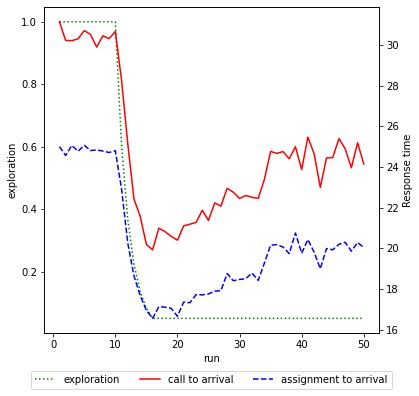


Test Model
----------
Run: 0, Mean assignment to arrival: 16.3, Mean call to arrival: 19.6, Demand met: 1.000
Run: 1, Mean assignment to arrival: 16.7, Mean call to arrival: 20.3, Demand met: 1.000
Run: 2, Mean assignment to arrival: 16.5, Mean call to arrival: 20.1, Demand met: 1.000
Run: 3, Mean assignment to arrival: 16.3, Mean call to arrival: 19.8, Demand met: 1.000
Run: 4, Mean assignment to arrival: 16.3, Mean call to arrival: 20.0, Demand met: 1.000
Run: 5, Mean assignment to arrival: 16.7, Mean call to arrival: 20.4, Demand met: 1.000
Run: 6, Mean assignment to arrival: 16.4, Mean call to arrival: 19.8, Demand met: 1.000
Run: 7, Mean assignment to arrival: 16.6, Mean call to arrival: 20.1, Demand met: 1.000
Run: 8, Mean assignment to arrival: 16.5, Mean call to arrival: 20.1, Demand met: 1.000
Run: 9, Mean assignment to arrival: 16.5, Mean call to arrival: 20.4, Demand met: 1.000
Run: 10, Mean assignment to arrival: 16.5, Mean call to arrival: 20.0, Demand met: 1.000
Run: 11,

In [8]:
######################## MODEL ENTRY POINT #####################################

# Run model and return last run results
last_run = qambo()